# **Rooftop Detction using Mask RCNN**



## Installation requirements

In [0]:
!git clone https://github.com/waleedka/coco
!pip install cython  
!git clone https://github.com/matterport/Mask_RCNN.git

In [0]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [0]:
import os
os.chdir("Mask_RCNN")

In [0]:
!mkdir rooftop_dataset
!scp -r ../drive/savera/4.MaskRCNN_rooftop/train_merged rooftop_dataset/train
!scp -r ../drive/savera/4.MaskRCNN_rooftop/val rooftop_dataset
!scp -r ../drive/savera/4.MaskRCNN_rooftop/test rooftop_dataset

In [0]:
!pip install git+https://github.com/aleju/imgaug

In [0]:
os.chdir("..")
!scp drive/Savera_me/MaskRCNN_Rooftop/custom_2.py Mask_RCNN/custom.py
os.chdir("Mask_RCNN")

## Model configurations


In [8]:
%%writefile custom.py

import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
#import cv2
#from mrcnn.visualize import display_instances
import matplotlib.pyplot as plt

# Root directory of the project
#ROOT_DIR = os.path.abspath("../../")
ROOT_DIR = os.getcwd()

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

############################################################
#  Configurations
############################################################


class CustomConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "roof"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + rooftop

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 47

    # Skip detections with < 70% confidence
    DETECTION_MIN_CONFIDENCE = 0.7
    
    #Image resizing
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 300
    IMAGE_MAX_DIM = 320


############################################################
#  Dataset
############################################################

class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):
        """Load a subset of the Balloon dataset.
        dataset_dir: Root directory of the dataset.
        subset: Subset to load: train or val
        """
        # Add classes. We have only one class to add.
        self.add_class("roof", 1, "roof")

        # Train or validation dataset?
        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)

        # Load annotations
        # VGG Image Annotator saves each image in the form:
        # { 'filename': '28503151_5b5b7ec140_b.jpg',
        #   'regions': {
        #       '0': {
        #           'region_attributes': {},
        #           'shape_attributes': {
        #               'all_points_x': [...],
        #               'all_points_y': [...],
        #               'name': 'polygon'}},
        #       ... more regions ...
        #   },
        #   'size': 100202
        # }
        # We mostly care about the x and y coordinates of each region
        annotations1 = json.load(open(os.path.join(dataset_dir, "via_region_data.json")))
        # print(annotations1)
        annotations = list(annotations1.values())  # don't need the dict keys

        # The VIA tool saves images in the JSON even if they don't have any
        # annotations. Skip unannotated images.
        annotations = [a for a in annotations if a['regions']]

        # Add images
        for a in annotations:
            # print(a)
            # Get the x, y coordinaets of points of the polygons that make up
            # the outline of each object instance. There are stores in the
            # shape_attributes (see json format above)
            roof_regions = [r for r in a['regions'] if r['region_attributes']['objects']=='roof']
            polygons = [r['shape_attributes'] for r in a['regions'] if r in roof_regions]
            
            # load_mask() needs the image size to convert polygons to masks.
            # Unfortunately, VIA doesn't include it in JSON, so we must read
            # the image. This is only managable since the dataset is tiny.
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "roof",  ## for a single class just add the name here
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons)

    def load_mask(self, image_id):
        """Generate instance masks for an image.
       Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a balloon dataset image, delegate to parent class.
        image_info = self.image_info[image_id]
        if image_info["source"] != "roof":
            return super(self.__class__, self).load_mask(image_id)

        # Convert polygons to a bitmap mask of shape
        # [height, width, instance_count]
        info = self.image_info[image_id]
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):
            # Get indexes of pixels inside the polygon and set them to 1
            rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])
            mask[rr, cc, i] = 1

        # Return mask, and array of class IDs of each instance. Since we have
        # one class ID only, we return an array of 1s
        return mask.astype(np.bool), np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "roof":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)


def train(model):
    """Train the model."""
    # Training dataset.
    dataset_train = CustomDataset()
    dataset_train.load_custom(args.dataset, "train")
    dataset_train.prepare()

    # Validation dataset
    dataset_val = CustomDataset()
    dataset_val.load_custom(args.dataset, "val")
    dataset_val.prepare()

    # *** This training schedule is an example. Update to your needs ***
    # Since we're using a very small dataset, and starting from
    # COCO trained weights, we don't need to train too long. Also,
    # no need to train all layers, just the heads should do it.
    print("Training network heads")
    model.train(dataset_train, dataset_val,
                learning_rate=config.LEARNING_RATE,
                epochs=15,
                layers='heads')
                #augmentation=imgaug.augmenters.Sequential([imgaug.augmenters.Fliplr(), imgaug.augmenters.Flipud()]))
    


def color_splash(image, mask):
    """Apply color splash effect.
    image: RGB image [height, width, 3]
    mask: instance segmentation mask [height, width, instance count]

    Returns result image.
    """
    # Make a grayscale copy of the image. The grayscale copy still
    # has 3 RGB channels, though.
    gray = skimage.color.gray2rgb(skimage.color.rgb2gray(image)) * 255
    # We're treating all instances as one, so collapse the mask into one layer
    mask = (np.sum(mask, -1, keepdims=True) >= 1)
    # Copy color pixels from the original color image where mask is set
    if mask.shape[0] > 0:
        splash = np.where(mask, image, gray).astype(np.uint8)
    else:
        splash = gray
    return splash


def detect_and_color_splash(model, image_path=None, video_path=None):
    assert image_path or video_path

    # Image or video?
    if image_path:
        # Run model detection and generate the color splash effect
        print("Running on {}".format(args.image))
        # Read image
        image = skimage.io.imread(args.image)
        # Detect objects
        r = model.detect([image], verbose=1)[0]
        # Color splash
        splash = color_splash(image, r['masks'])
        # Save output
        file_name = "splash_{:%Y%m%dT%H%M%S}.png".format(datetime.datetime.now())
        skimage.io.imsave(file_name, splash)
    elif video_path:
        import cv2
        # Video capture
        vcapture = cv2.VideoCapture(video_path)
        width = int(vcapture.get(cv2.CAP_PROP_FRAME_WIDTH))
        height = int(vcapture.get(cv2.CAP_PROP_FRAME_HEIGHT))
        fps = vcapture.get(cv2.CAP_PROP_FPS)

        # Define codec and create video writer
        file_name = "splash_{:%Y%m%dT%H%M%S}.avi".format(datetime.datetime.now())
        vwriter = cv2.VideoWriter(file_name,
                                  cv2.VideoWriter_fourcc(*'MJPG'),
                                  fps, (width, height))

        count = 0
        success = True
        while success:
            print("frame: ", count)
            # Read next image
            success, image = vcapture.read()
            if success:
                # OpenCV returns images as BGR, convert to RGB
                image = image[..., ::-1]
                # Detect objects
                r = model.detect([image], verbose=0)[0]
                # Color splash
                splash = color_splash(image, r['masks'])
                # RGB -> BGR to save image to video
                splash = splash[..., ::-1]
                # Add image to video writer
                vwriter.write(splash)
                count += 1
        vwriter.release()
    print("Saved to ", file_name)

############################################################
#  Training
############################################################

if __name__ == '__main__':
    import argparse

    # Parse command line arguments
    parser = argparse.ArgumentParser(
        description='Train Mask R-CNN to detect rooftops.')
    parser.add_argument("command",
                        metavar="<command>",
                        help="'train' or 'splash'")
    parser.add_argument('--dataset', required=False,
                        metavar="/path/to/rooftop/dataset/",
                        help='Directory of the rooftop dataset')
    parser.add_argument('--weights', required=True,
                        metavar="/path/to/weights.h5",
                        help="Path to weights .h5 file or 'coco'")
    parser.add_argument('--logs', required=False,
                        default=DEFAULT_LOGS_DIR,
                        metavar="/path/to/logs/",
                        help='Logs and checkpoints directory (default=logs/)')
    parser.add_argument('--image', required=False,
                        metavar="path or URL to image",
                        help='Image to apply the color splash effect on')
    parser.add_argument('--video', required=False,
                        metavar="path or URL to video",
                        help='Video to apply the color splash effect on')
    args = parser.parse_args()

    # Validate arguments
    if args.command == "train":
        assert args.dataset, "Argument --dataset is required for training"
    elif args.command == "splash":
        assert args.image or args.video,\
               "Provide --image or --video to apply color splash"

    print("Weights: ", args.weights)
    print("Dataset: ", args.dataset)
    print("Logs: ", args.logs)

    # Configurations
    if args.command == "train":
        config = CustomConfig()
    else:
        class InferenceConfig(CustomConfig):
            # Set batch size to 1 since we'll be running inference on
            # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
            GPU_COUNT = 1
            IMAGES_PER_GPU = 1
        config = InferenceConfig()
    config.display()

    # Create model
    if args.command == "train":
        model = modellib.MaskRCNN(mode="training", config=config,
                                  model_dir=args.logs)
    else:
        model = modellib.MaskRCNN(mode="inference", config=config,
                                  model_dir=args.logs)

    # Select weights file to load
    if args.weights.lower() == "coco":
        weights_path = COCO_WEIGHTS_PATH
        # Download weights file
        if not os.path.exists(weights_path):
            utils.download_trained_weights(weights_path)
    elif args.weights.lower() == "last":
        # Find last trained weights
        weights_path = model.find_last()[1]
    elif args.weights.lower() == "imagenet":
        # Start from ImageNet trained weights
        weights_path = model.get_imagenet_weights()
    else:
        weights_path = args.weights

    # Load weights
    print("Loading weights ", weights_path)
    if args.weights.lower() == "coco":
        # Exclude the last layers because they require a matching
        # number of classes
        model.load_weights(weights_path, by_name=True, exclude=[
            "mrcnn_class_logits", "mrcnn_bbox_fc",
            "mrcnn_bbox", "mrcnn_mask"])
    else:
        model.load_weights(weights_path, by_name=True)

    # Train or evaluate
    if args.command == "train":
        train(model)
    elif args.command == "splash":
        detect_and_color_splash(model, image_path=args.image,
                                video_path=args.video)
    else:
        print("'{}' is not recognized. "
              "Use 'train' or 'splash'".format(args.command))

Overwriting custom.py


In [9]:
!python3 custom.py train --dataset=rooftop_dataset/ --weights=coco

Using TensorFlow backend.
Weights:  coco
Dataset:  rooftop_dataset/
Logs:  /content/Mask_RCNN/logs

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 2
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  320
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  300
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [320 320   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn

In [11]:
!ls logs/roof20181207T1623

events.out.tfevents.1544199813.dd5a8f8fc5e8  mask_rcnn_roof_0008.h5
mask_rcnn_roof_0001.h5			     mask_rcnn_roof_0009.h5
mask_rcnn_roof_0002.h5			     mask_rcnn_roof_0010.h5
mask_rcnn_roof_0003.h5			     mask_rcnn_roof_0011.h5
mask_rcnn_roof_0004.h5			     mask_rcnn_roof_0012.h5
mask_rcnn_roof_0005.h5			     mask_rcnn_roof_0013.h5
mask_rcnn_roof_0006.h5			     mask_rcnn_roof_0014.h5
mask_rcnn_roof_0007.h5			     mask_rcnn_roof_0015.h5


## Tensorboard

In [0]:
LOG_DIR = 'logs/roof20181207T1440'
get_ipython().system_raw(
    'tensorboard --logdir {} --host 0.0.0.0 --port 6007 &'
    .format(LOG_DIR)
)

In [0]:
! wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip ngrok-stable-linux-amd64.zip

In [0]:
get_ipython().system_raw('./ngrok http 6007 &')


In [31]:
! curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

http://a023e88a.ngrok.io


## Test the model

In [12]:
import os
import sys
import random
import math
import numpy as np
import skimage.io
import matplotlib
import matplotlib.pyplot as plt
import custom

# Root directory of the project
ROOT_DIR = os.getcwd()

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize

'''
# Import COCO config
sys.path.append(os.path.join(ROOT_DIR, "samples/coco/"))  # To find local version
import coco
'''
%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

'''
# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)
'''
custom_WEIGHTS_PATH = os.path.join(os.path.join("logs","roof20181207T1623"),"mask_rcnn_roof_0015.h5")  # TODO: update this path

# Directory of images to run detection on
IMAGE_DIR = os.path.join(ROOT_DIR, "rooftop_dataset/test")
config = custom.CustomConfig()

Using TensorFlow backend.


In [13]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  320
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  300
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [320 320   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE             

In [0]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/gpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [15]:
# Create model in inference mode
import tensorflow as tf
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,config=config)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.


In [16]:
# Load weights
print("Loading weights ", custom_WEIGHTS_PATH)
model.load_weights(custom_WEIGHTS_PATH, by_name=True)

Loading weights  logs/roof20181207T1623/mask_rcnn_roof_0015.h5
Re-starting from epoch 15


In [0]:
def get_ax(rows=1, cols=1, size=10):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [19]:
# Load validation dataset
dataset = custom.CustomDataset()
dataset.load_custom(CUSTOM_DIR, "val")

# Must call before using the dataset
dataset.prepare()

print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

Images: 17
Classes: ['BG', 'roof']


## Results

Processing 1 images
image                    shape: (300, 300, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  int64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32


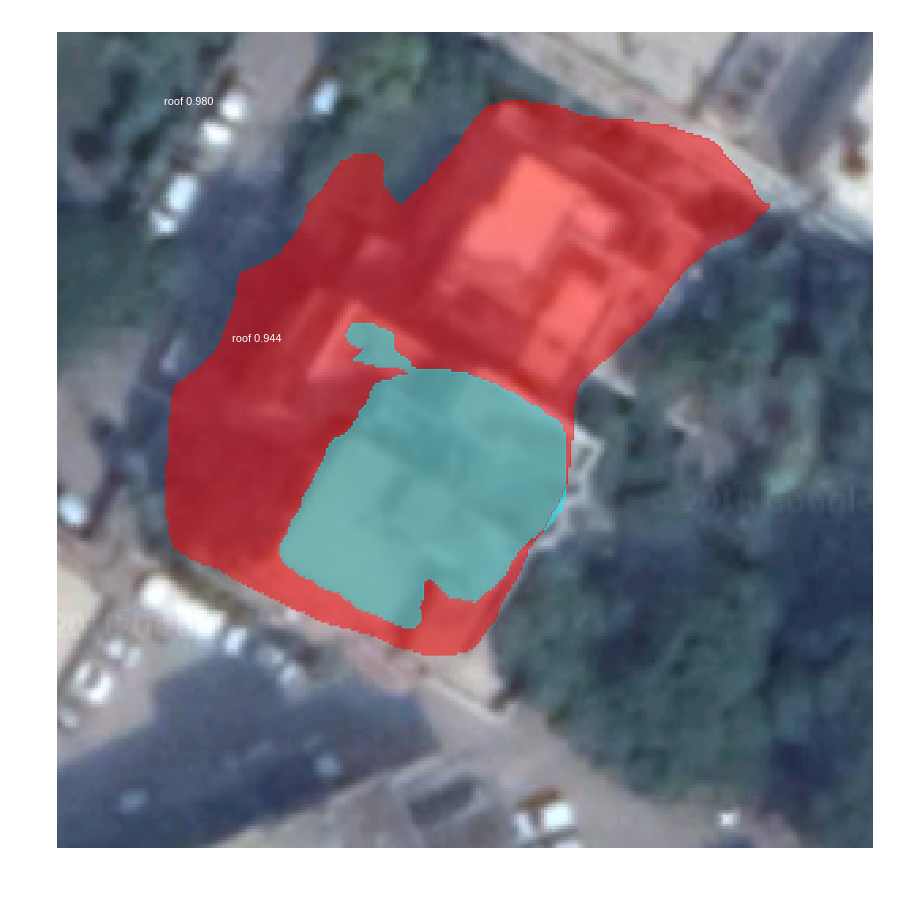

Processing 1 images
image                    shape: (300, 300, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  int64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32


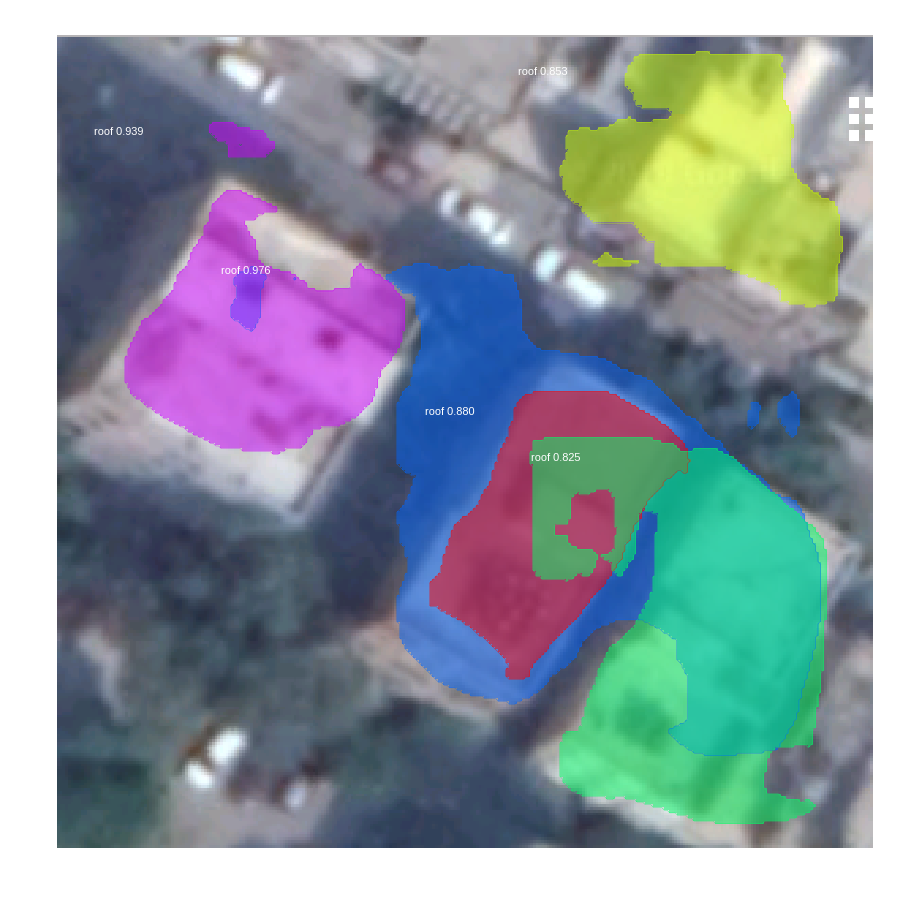

Processing 1 images
image                    shape: (300, 300, 3)         min:   49.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  int64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32


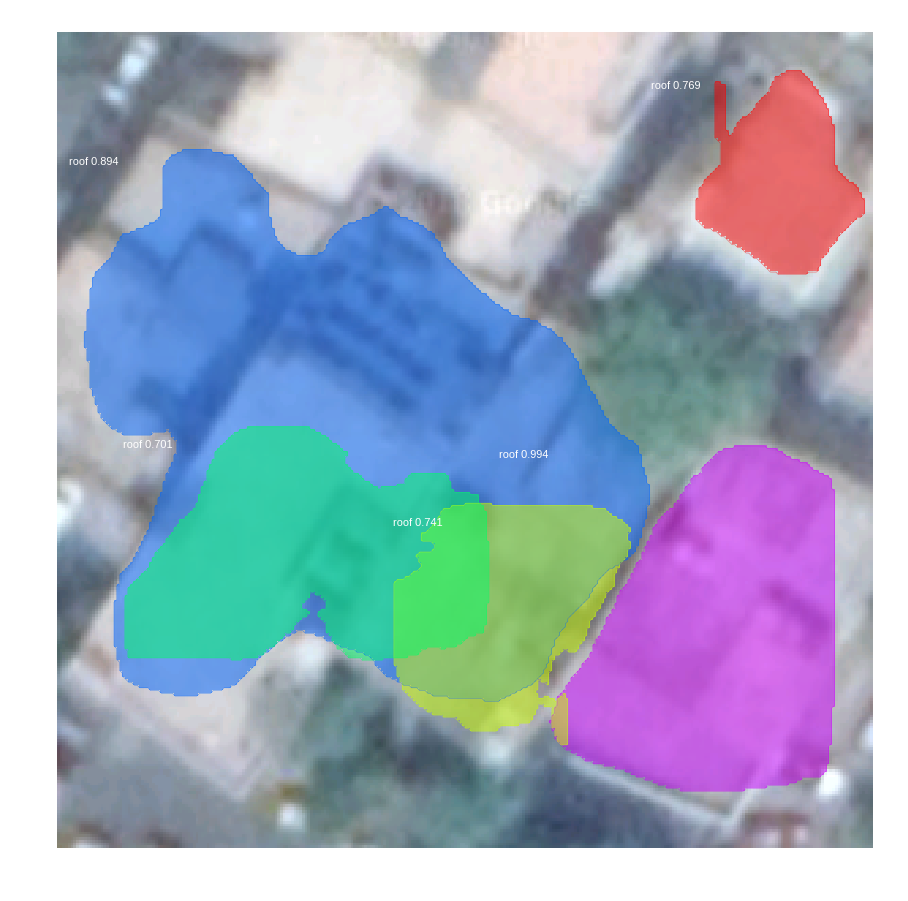

Processing 1 images
image                    shape: (300, 300, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  int64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32


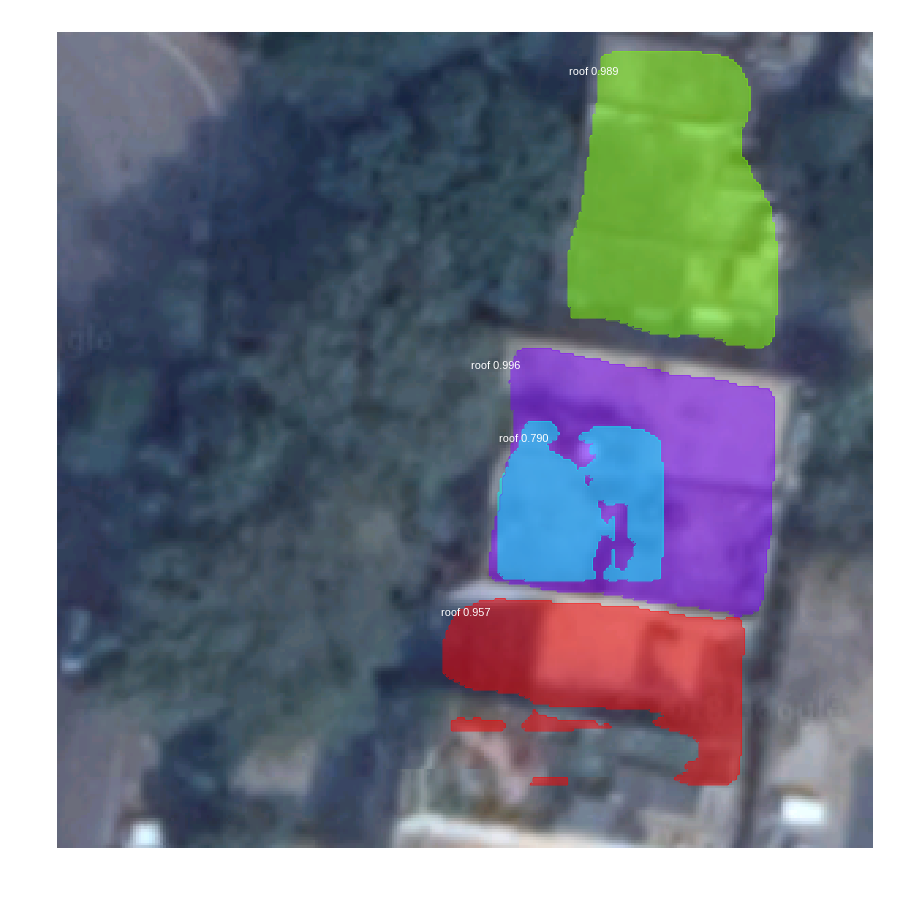

Processing 1 images
image                    shape: (300, 300, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  int64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32


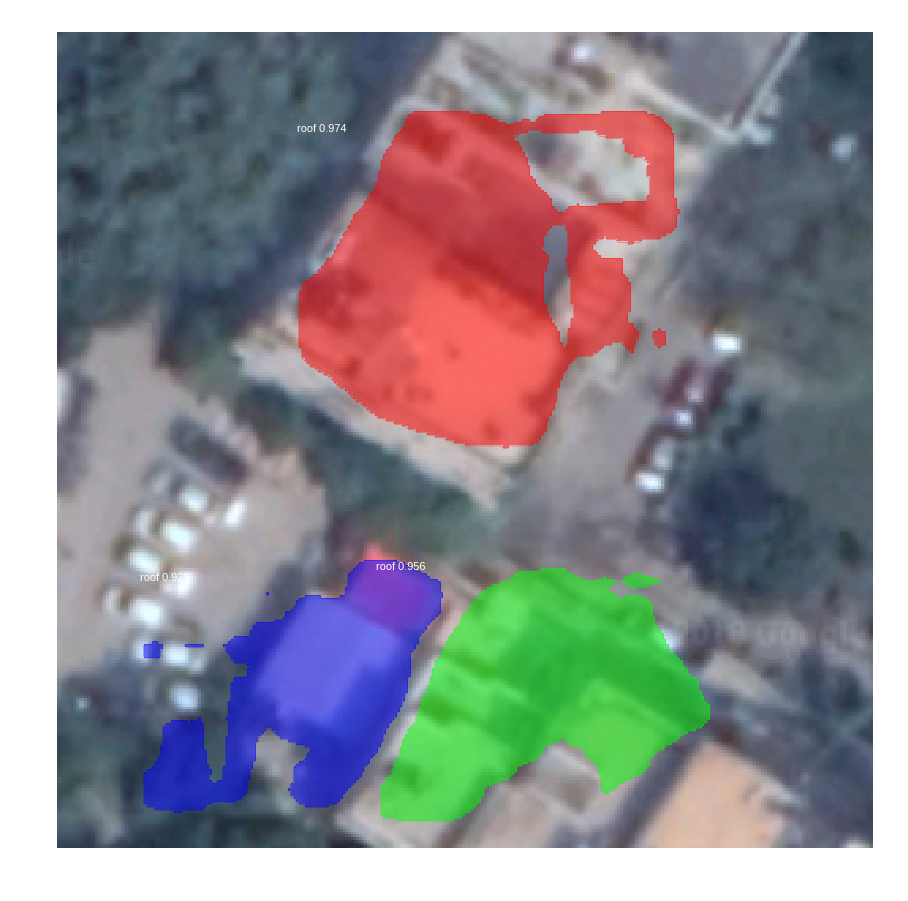

Processing 1 images
image                    shape: (300, 300, 3)         min:   36.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  int64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32


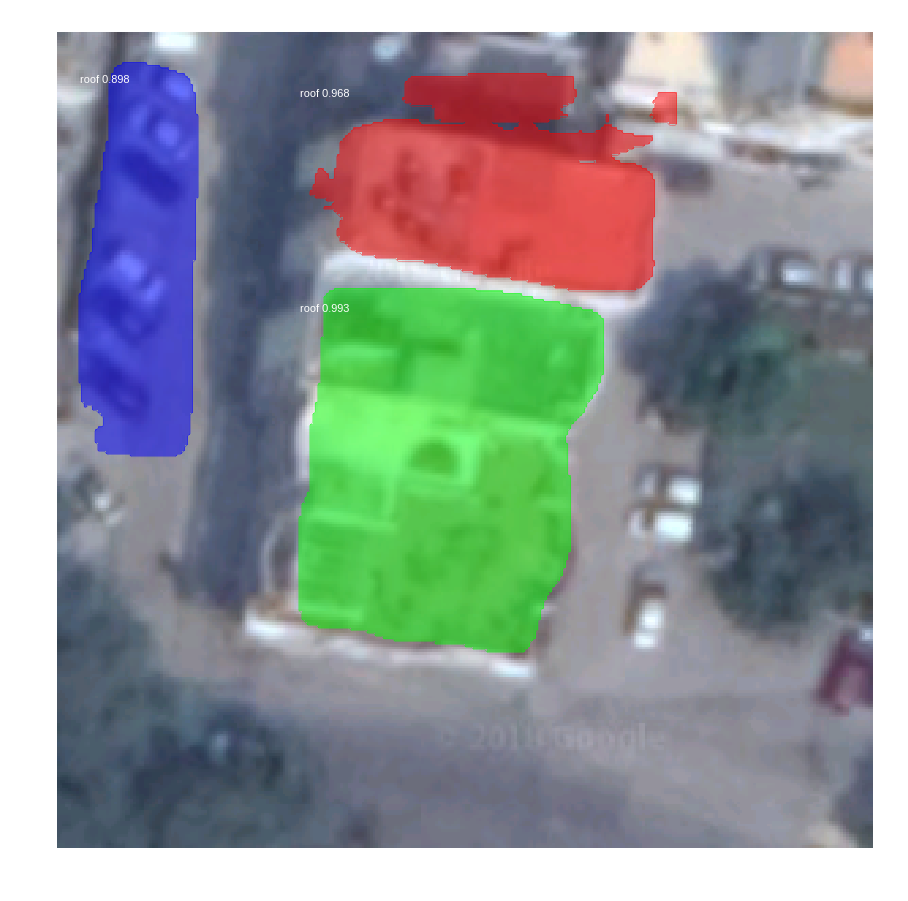

Processing 1 images
image                    shape: (300, 300, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  int64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32


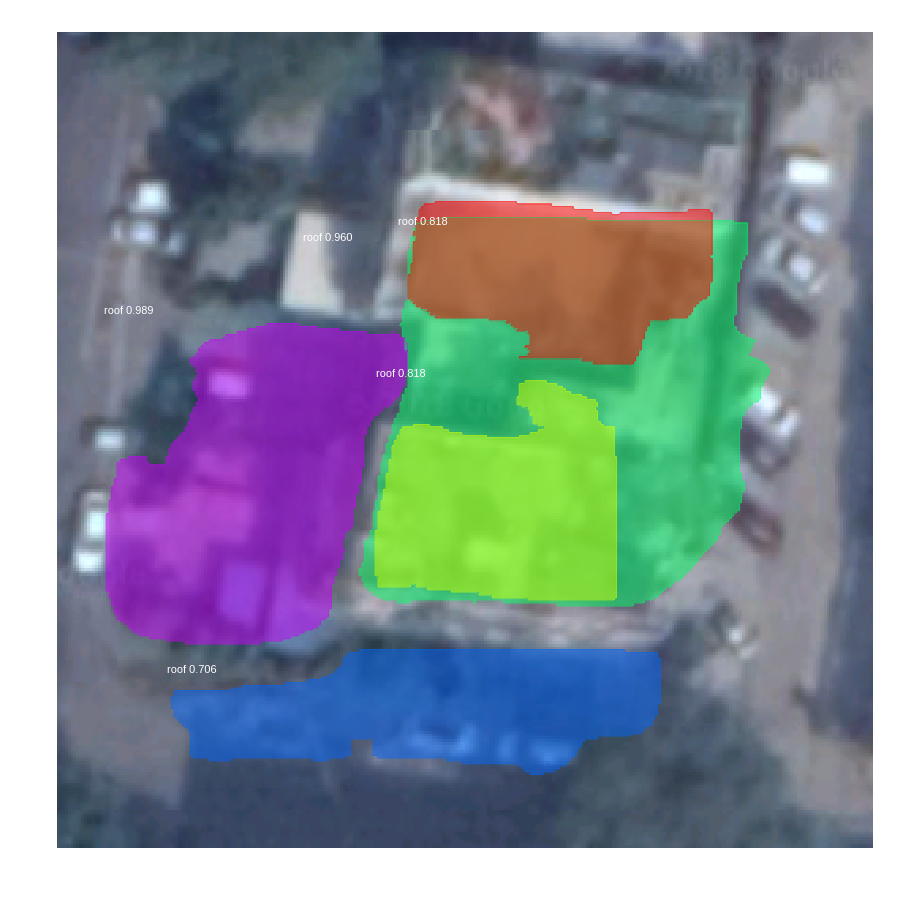

Processing 1 images
image                    shape: (300, 300, 3)         min:   24.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  int64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32


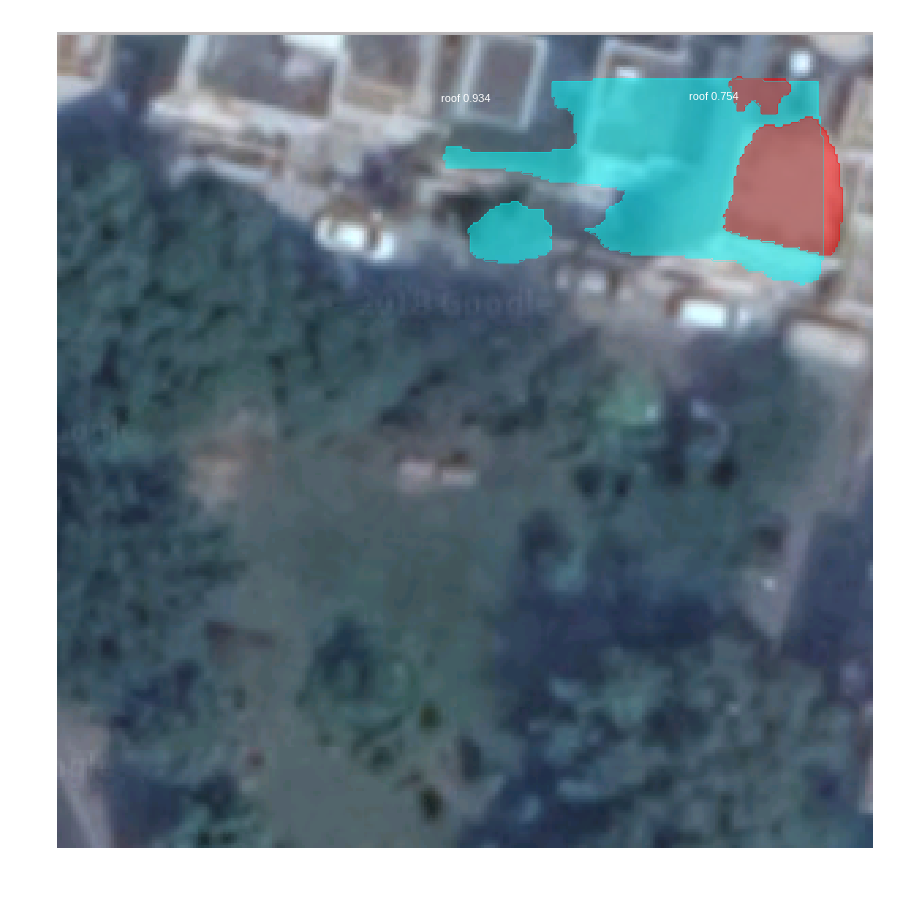

Processing 1 images
image                    shape: (300, 300, 3)         min:   23.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  int64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32


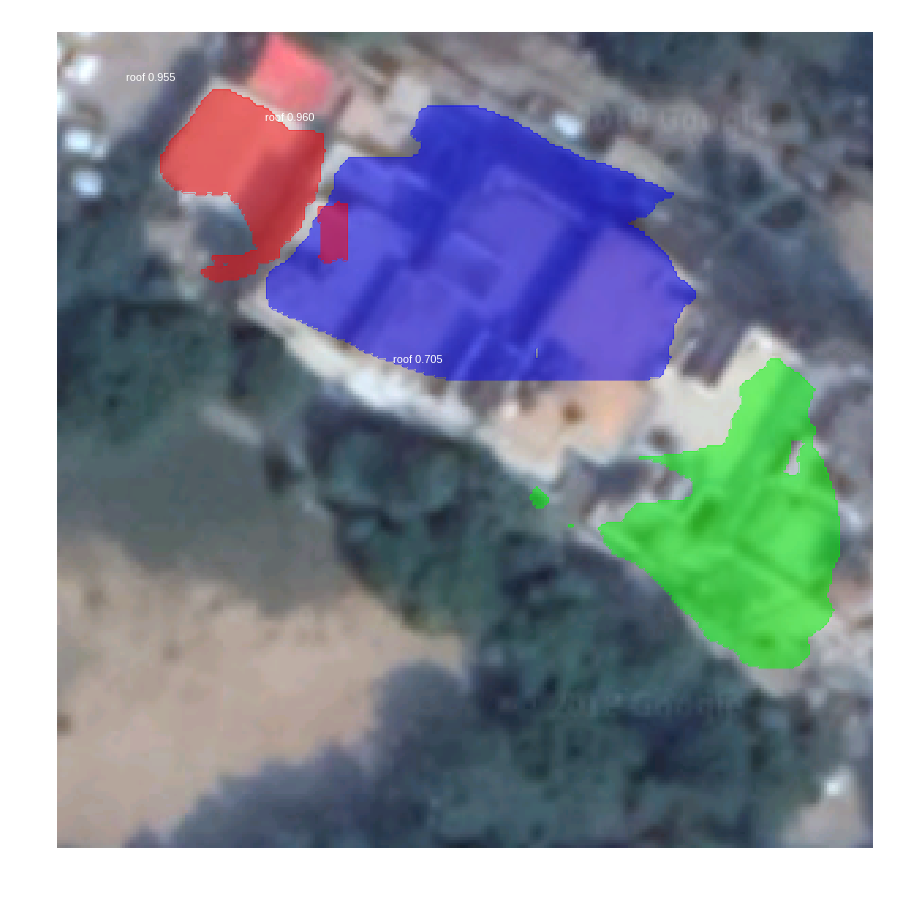

Processing 1 images
image                    shape: (300, 300, 3)         min:   49.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  int64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32


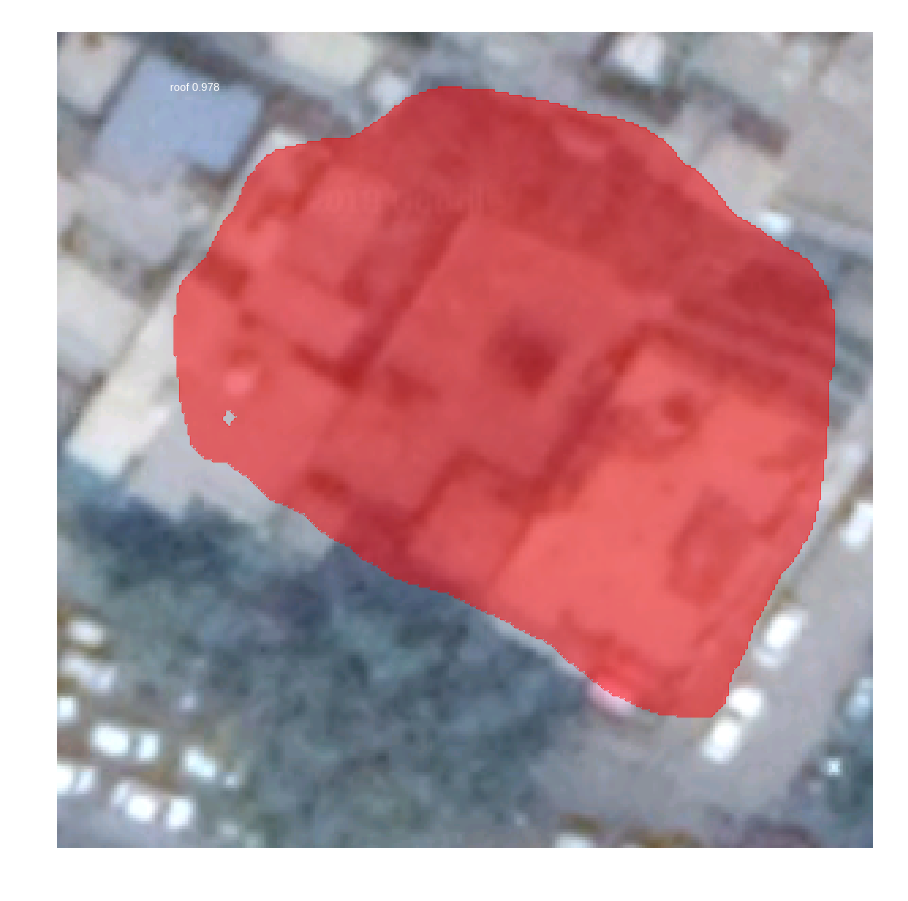

Processing 1 images
image                    shape: (300, 300, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  int64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32


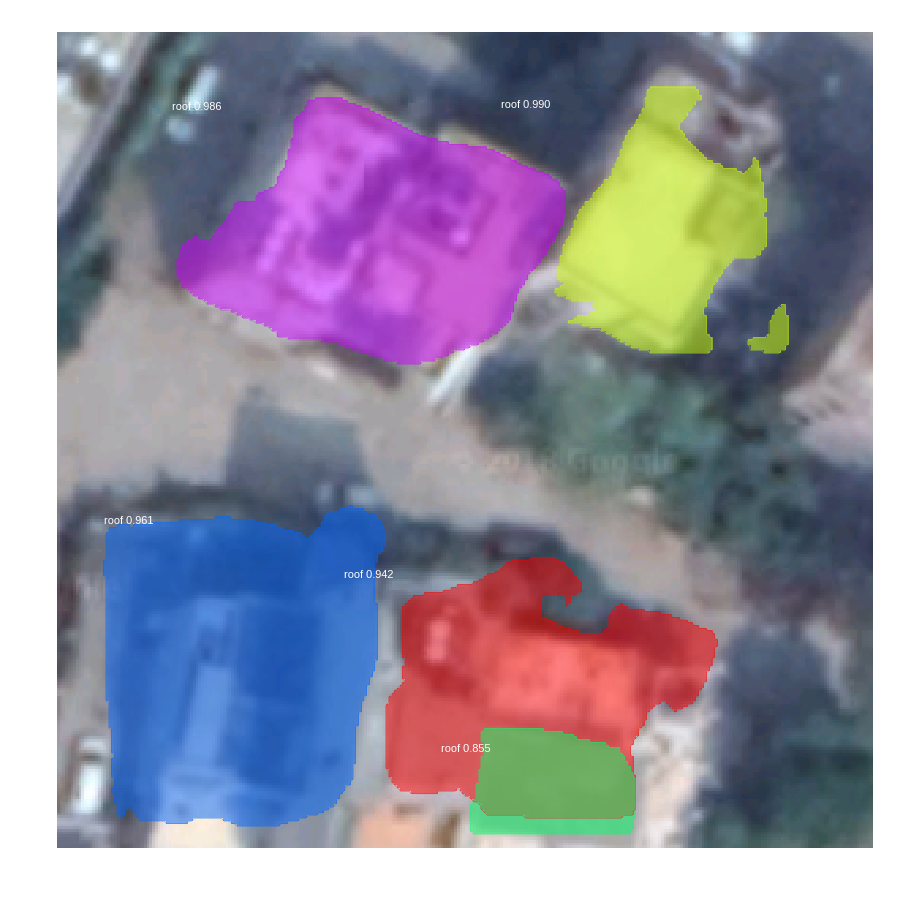

Processing 1 images
image                    shape: (300, 300, 3)         min:   33.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  int64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32


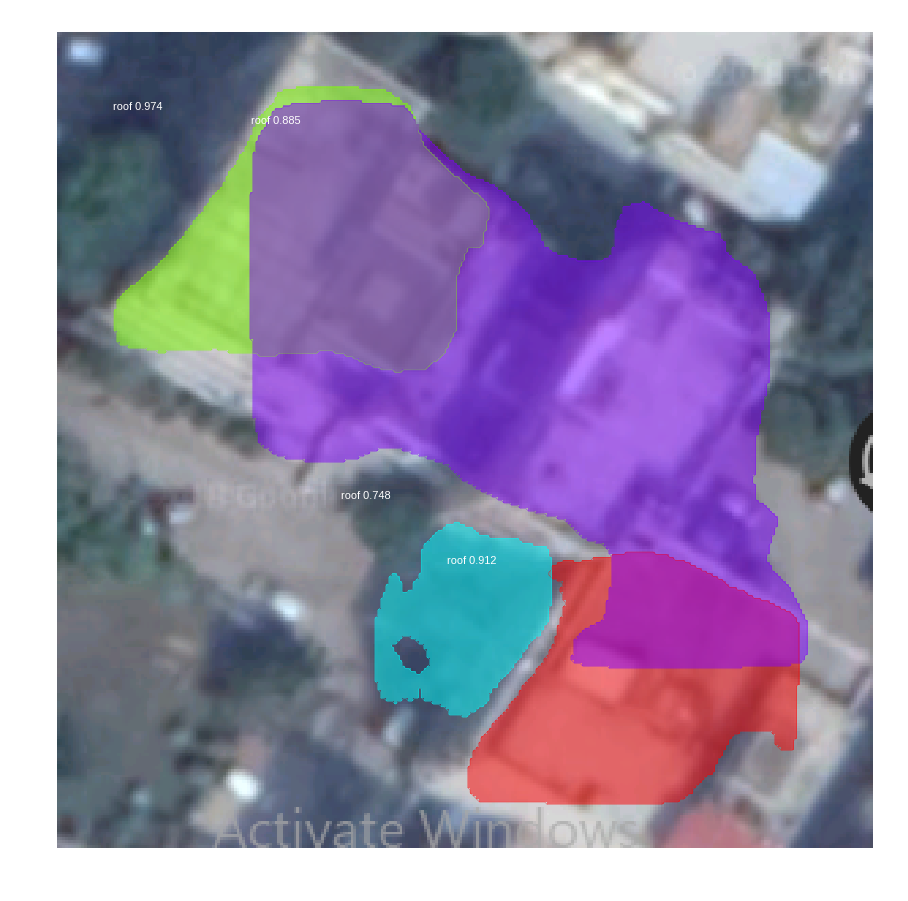

Processing 1 images
image                    shape: (300, 300, 3)         min:   49.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  int64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32


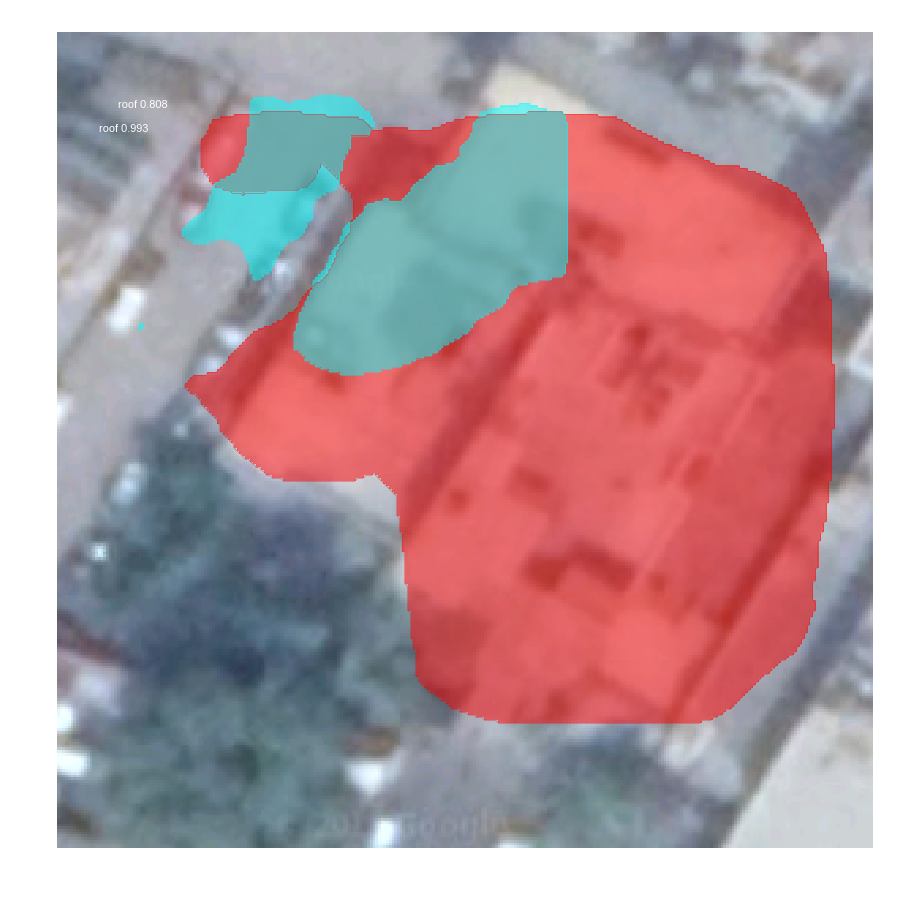

Processing 1 images
image                    shape: (300, 300, 3)         min:   57.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  int64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32


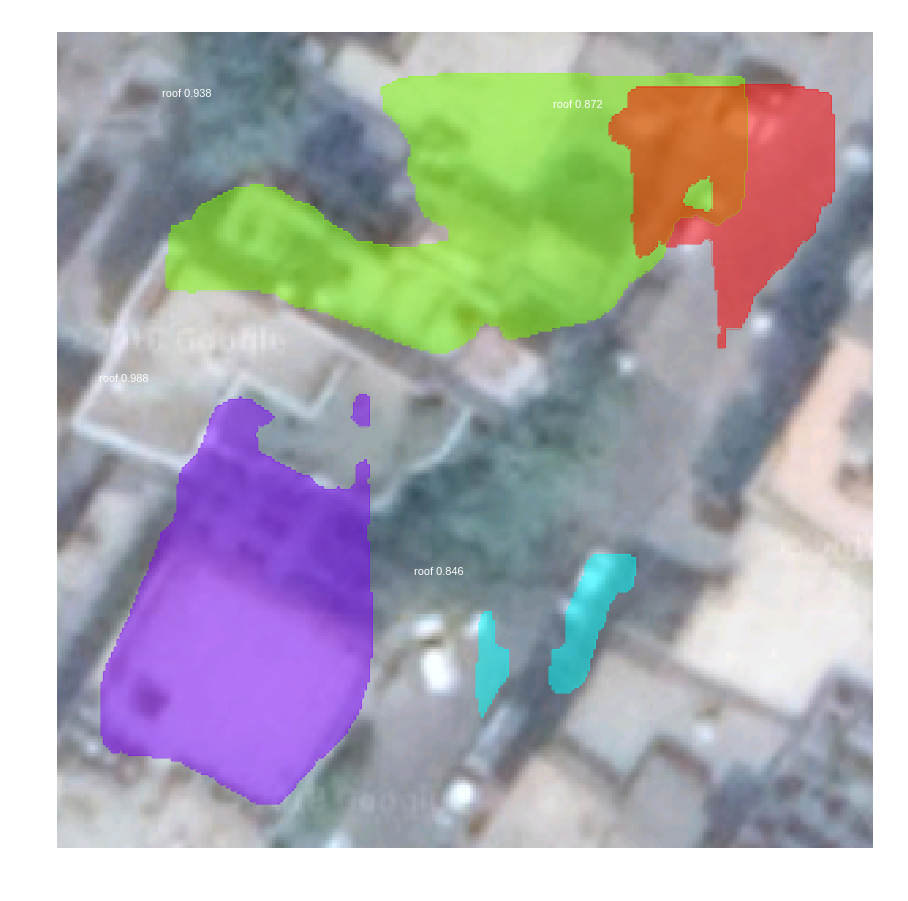

Processing 1 images
image                    shape: (300, 300, 3)         min:   16.00000  max:  255.00000  uint8
molded_images            shape: (1, 320, 320, 3)      min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  320.00000  int64
anchors                  shape: (1, 25575, 4)         min:   -1.13492  max:    1.93429  float32


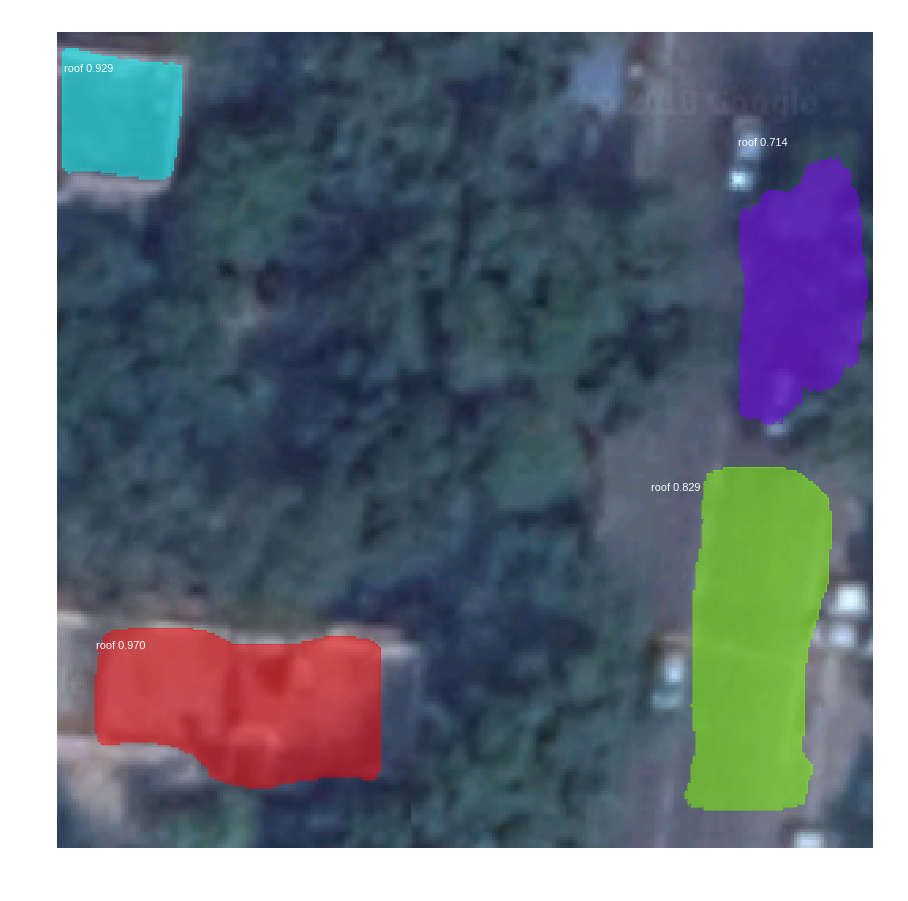

In [24]:
# Load a random image from the images folder
for file_names in os.listdir(IMAGE_DIR):
  #file_names = next(os.walk(IMAGE_DIR))[2]
  #image = skimage.io.imread(os.path.join(IMAGE_DIR, random.choice(file_names)))
  image = skimage.io.imread(os.path.join(IMAGE_DIR,file_names))

  # Run detection
  results = model.detect([image], verbose=1)

  # Visualize results
  r = results[0]
  visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                              dataset.class_names, r['scores'], show_bbox=False)

In [21]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
#image_ids = np.random.choice(dataset.image_ids, 10)
image_ids=np.array([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])
#print(dataset.image_ids)
APs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask = modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    print(image_id, gt_mask.shape, r['masks'].shape)
    # Compute AP
    AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
print("mAP: ", np.mean(APs))

0 (320, 320, 1) (320, 320, 1)
1 (320, 320, 3) (320, 320, 3)
2 (320, 320, 1) (320, 320, 1)
3 (320, 320, 2) (320, 320, 2)
4 (320, 320, 1) (320, 320, 5)
5 (320, 320, 1) (320, 320, 1)
6 (320, 320, 1) (320, 320, 1)
7 (320, 320, 2) (320, 320, 3)
8 (320, 320, 2) (320, 320, 5)
9 (320, 320, 5) (320, 320, 8)
10 (320, 320, 2) (320, 320, 1)
11 (320, 320, 1) (320, 320, 2)
12 (320, 320, 1) (320, 320, 5)
13 (320, 320, 1) (320, 320, 7)
14 (320, 320, 1) (320, 320, 1)
15 (320, 320, 1) (320, 320, 2)
16 (320, 320, 1) (320, 320, 1)
mAP:  0.7981372560210087
